In [1]:
!pip install tensorflow
import os

# Defining each of these directories

In [2]:
# Directory with our training horse pictures
train_hammer_dir = os.path.join('../input/mechanical-tools-dataset/train_data/train_data/Hammer')

# Directory with our training human pictures
train_Screwdriver_dir = os.path.join('../input/mechanical-tools-dataset/train_data/train_data/Screw Driver')

**Now, let's see what the filenames look like in the training directories:**

In [3]:
train_hammer_names = os.listdir(train_hammer_dir)
print(train_hammer_names[:20])

train_screw_names = os.listdir(train_Screwdriver_dir)
print(train_screw_names[:20])

['Hammer (1189).JPEG', '000197.jpg', 'Hammer (1656).JPEG', 'Hammer (1027).JPEG', 'Hammer (1177).JPEG', 'Hammer (1379).JPEG', '000436.jpg', '000084.jpg', '000357.jpg', '000142.jpg', '000268.jpg', 'Hammer (987).JPEG', '000033.jpg', 'Hammer (881).JPEG', '000196.jpg', 'Hammer (1388).JPEG', 'Hammer (1375).JPEG', '000147.jpg', 'Hammer (1218).JPEG', '000449.jpg']
['Screwdriver (779).JPEG', '000197.jpg', 'Screwdriver (298).JPEG', 'Screwdriver (452).JPEG', '000436.jpg', 'Screwdriver (662).JPEG', 'Screwdriver (10).JPEG', '000084.jpg', '000357.jpg', '000142.jpg', '000268.jpg', '000033.jpg', '000196.jpg', '000232.jpg', '000453.jpg', '000460.jpg', '000147.jpg', '000449.jpg', '000024.jpg', 'Screwdriver (694).JPEG']


**Let's find out the number of hammer and screwdriver images in the directory**

In [4]:
print('total training hammer images:', len(os.listdir(train_hammer_dir)))
print('total training screwdriver images:', len(os.listdir(train_Screwdriver_dir)))

total training hammer images: 1326
total training screwdriver images: 1326


**Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:**

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 10x10 configuration
nrows = 10
ncols = 10

# Index for iterating over images
pic_index = 0

**Now, display a batch of 50 hammer and 50 screwdriver pictures. You can rerun the cell to see a fresh batch each time:**

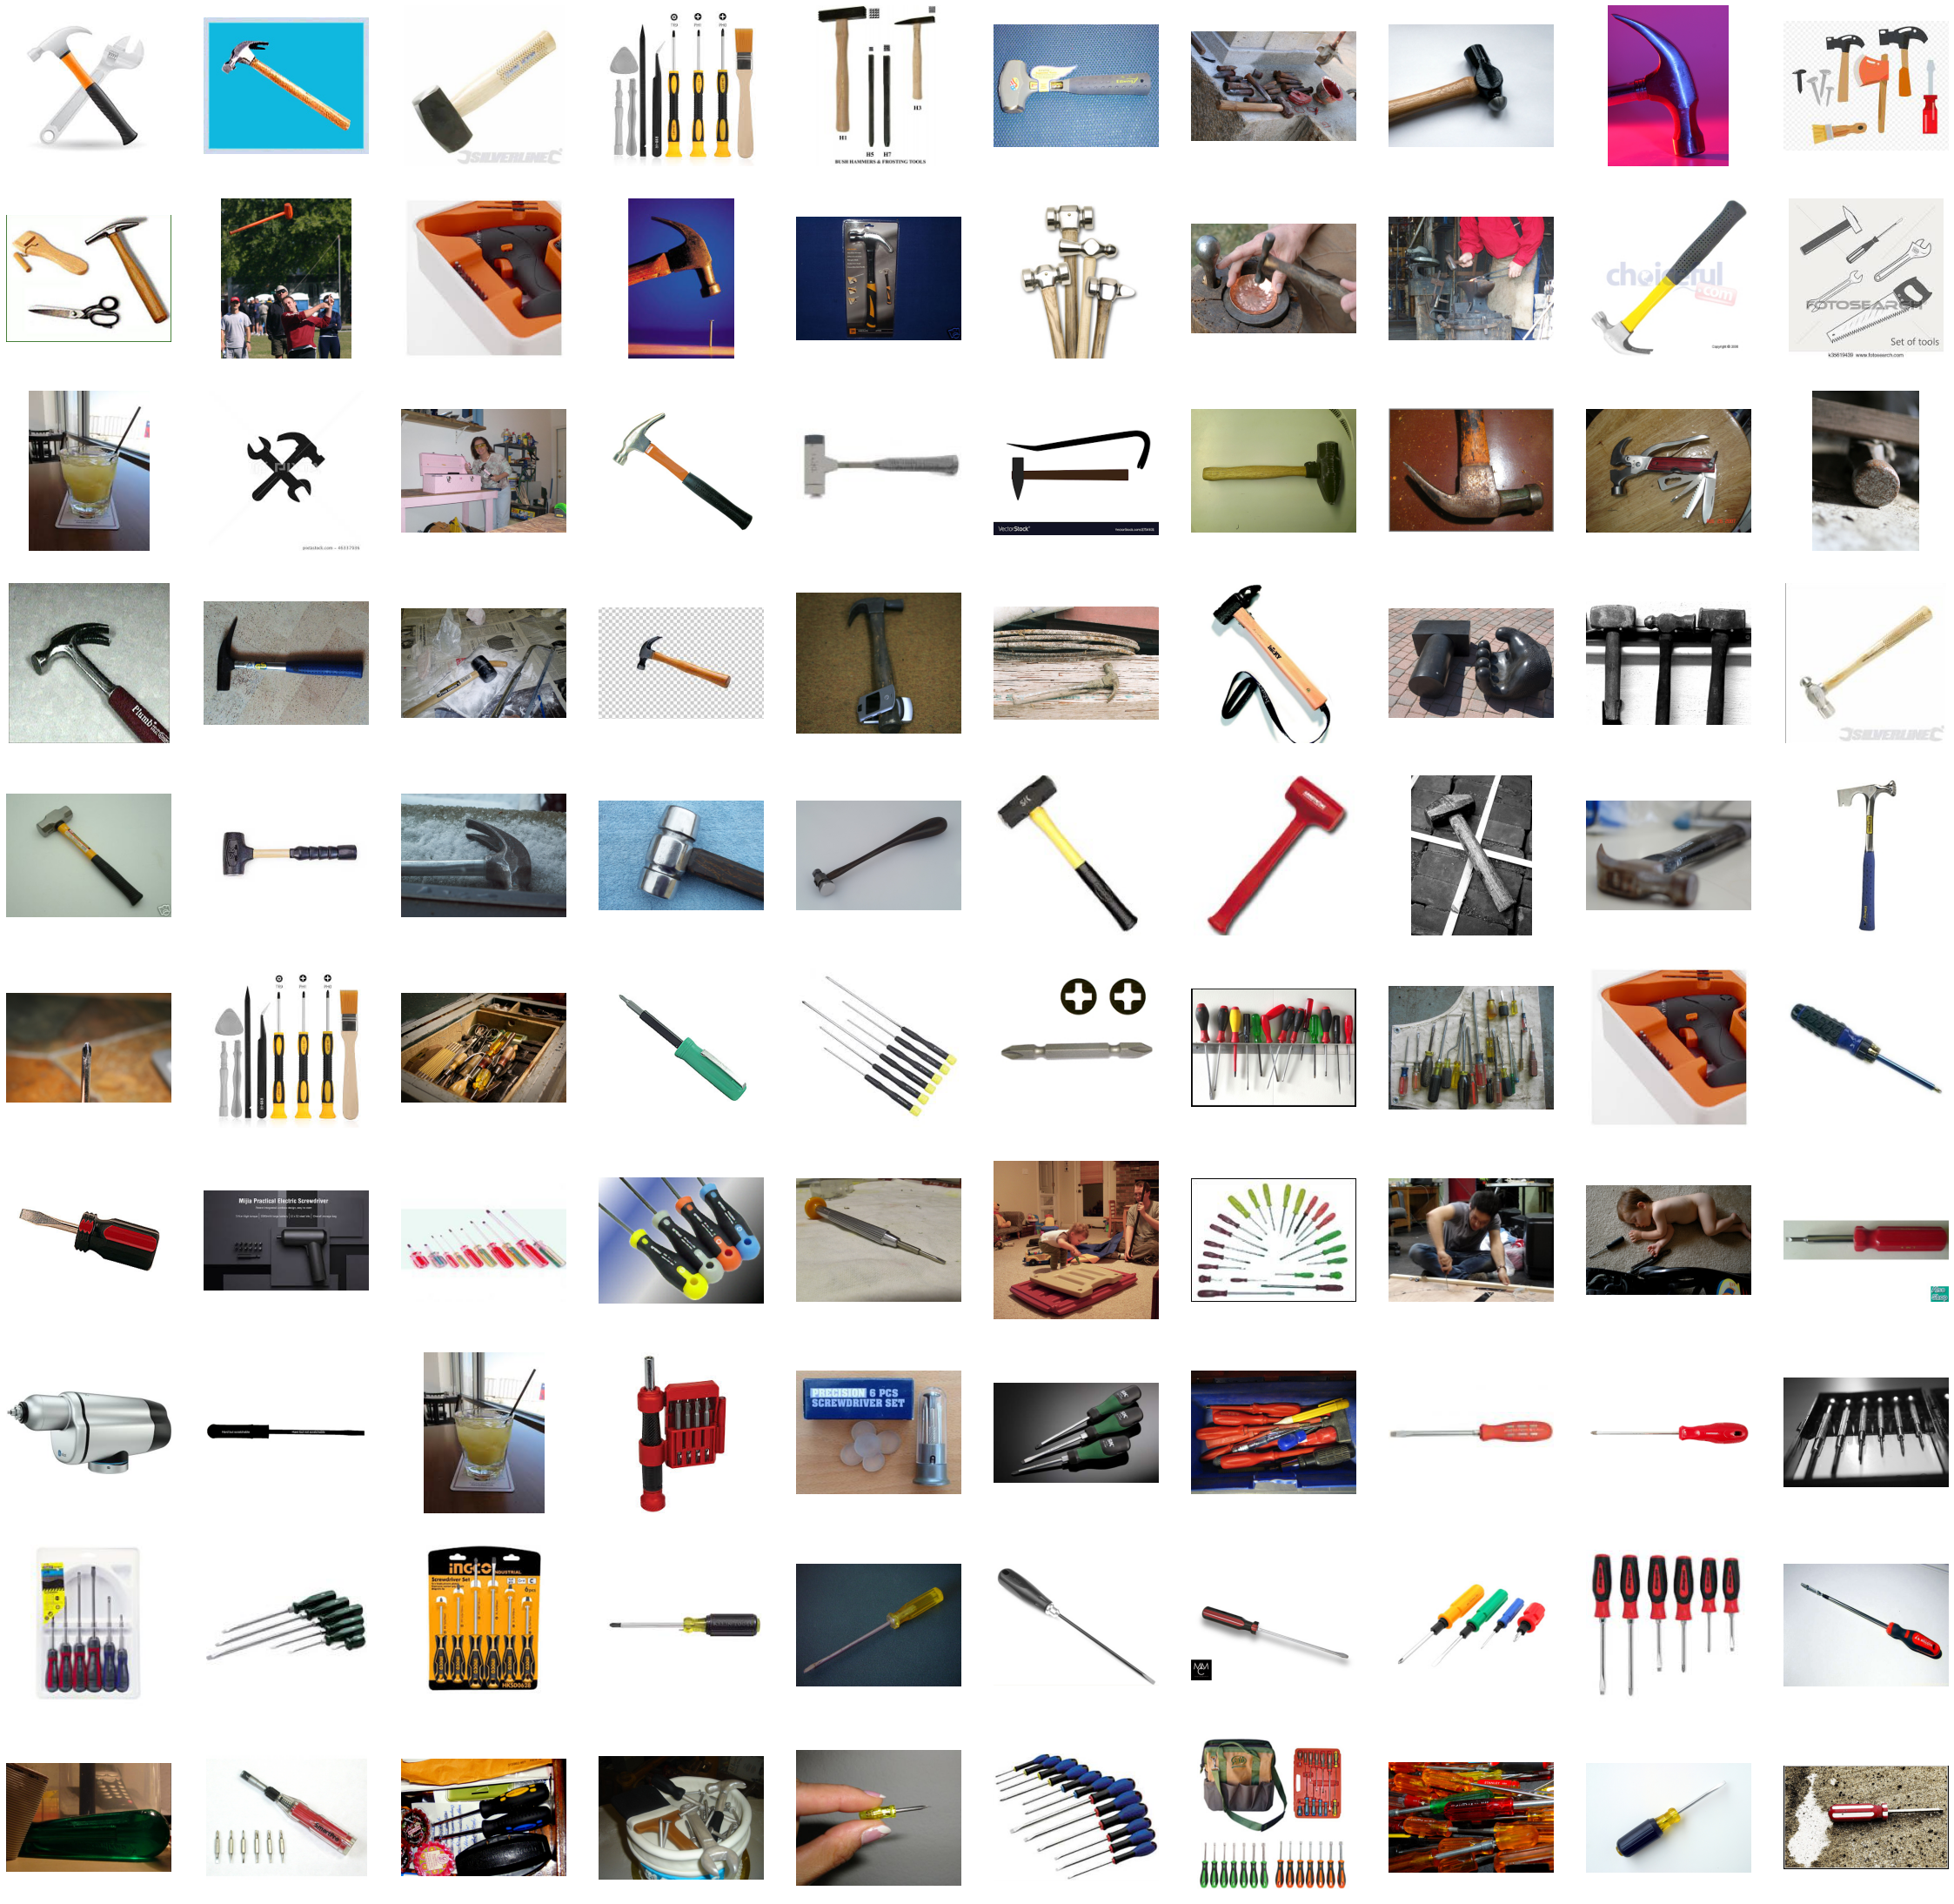

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 200
next_hammer_pix = [os.path.join(train_hammer_dir, fname) 
                for fname in train_hammer_names[pic_index-50:pic_index]]
next_driver_pix = [os.path.join(train_Screwdriver_dir, fname) 
                for fname in train_screw_names[pic_index-50:pic_index]]

for i, img_path in enumerate(next_hammer_pix+next_driver_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

**Building a Model from Scratch
But before we continue, let's start defining the model:
Step 1 will be to import tensorflow.**

In [7]:
import tensorflow as tf

**We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.**
**Note that because we are facing a two-class classification problem, i.e. a binary classification problem, we will end our network with a sigmoid activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).**

In [8]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('hammer') and 1 for the other ('screwdriver')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        1

**The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.**

**Next, we'll configure the specifications for model training. We will train our model with the binary_crossentropy loss, because it's a binary classification problem and our final activation is a sigmoid. We will use the rmsprop optimizer with a learning rate of 0.001. During training, we will want to monitor classification accuracy.
NOTE: In this case, using the RMSprop optimization algorithm is preferable to stochastic gradient descent (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as Adam and Adagrad, also automatically adapt the learning rate during training, and would work equally well here.)**

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

# Data Preprocessing
**Let's set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary).
As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).
In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit, evaluate_generator, and predict_generator.**

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '../input/mechanical-tools-dataset/train_data/train_data',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 2652 images belonging to 2 classes.


**Training
Let's train for 15 epochs -- this may take a few minutes to run.
Do note the values per epoch.
The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses.**

In [12]:
history = model.fit(
      train_generator,
      steps_per_epoch=10,  
      epochs=40,
      verbose=2)

Epoch 1/40
10/10 - 7s - loss: 1.0070 - accuracy: 0.4952
Epoch 2/40
10/10 - 7s - loss: 0.6916 - accuracy: 0.5148
Epoch 3/40
10/10 - 9s - loss: 0.6905 - accuracy: 0.5445
Epoch 4/40
10/10 - 8s - loss: 0.6892 - accuracy: 0.5531
Epoch 5/40
10/10 - 7s - loss: 0.6914 - accuracy: 0.5430
Epoch 6/40
10/10 - 8s - loss: 0.6708 - accuracy: 0.5758
Epoch 7/40
10/10 - 7s - loss: 0.6762 - accuracy: 0.5788
Epoch 8/40
10/10 - 6s - loss: 0.6748 - accuracy: 0.5892
Epoch 9/40
10/10 - 6s - loss: 0.6631 - accuracy: 0.6158
Epoch 10/40
10/10 - 6s - loss: 0.6564 - accuracy: 0.5997
Epoch 11/40
10/10 - 7s - loss: 0.7319 - accuracy: 0.6062
Epoch 12/40
10/10 - 6s - loss: 0.6194 - accuracy: 0.6453
Epoch 13/40
10/10 - 6s - loss: 0.6579 - accuracy: 0.6053
Epoch 14/40
10/10 - 7s - loss: 0.6507 - accuracy: 0.6503
Epoch 15/40
10/10 - 7s - loss: 0.6270 - accuracy: 0.6527
Epoch 16/40
10/10 - 6s - loss: 0.6387 - accuracy: 0.6227
Epoch 17/40
10/10 - 6s - loss: 0.5976 - accuracy: 0.6719
Epoch 18/40
10/10 - 6s - loss: 0.5781 - 

**Running the Model
Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is a hammer or a screwdriver.**

NameError: name 'np' is not defined

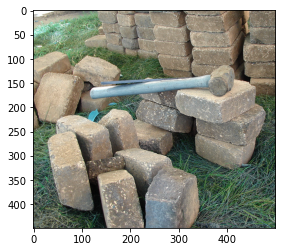

In [13]:
import cv2
import numpy as numpy
img = cv2.imread('../input/mechanical-tools-dataset/test_data/test_data/Hammer (1891).JPEG')
plt.imshow(img)
img = cv2.resize(img,(300,300))
img = np.reshape(img,[1,300,300,3])

classes = model.predict_classes(img)

print(classes)
if classes>0.5:
    print("This is a Screw Driver")
else:
    print("This is a Hammer")

NameError: name 'np' is not defined

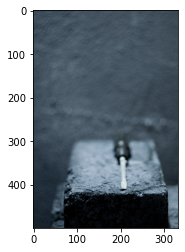

In [14]:
img = cv2.imread('../input/mechanical-tools-dataset/test_data/test_data/Screwdriver (1414).JPEG')
plt.imshow(img)
img = cv2.resize(img,(300,300))
img = np.reshape(img,[1,300,300,3])

classes = model.predict_classes(img)

print(classes)
if classes>0.5:
    print("This is a Screw Driver")
else:
    print("This is a Hammer")

**Therefore the accuracy of 77.2% implies that the model can accurately predict around 2047 images accurately from the training data out of 2652 images of either Hammer or screw driver**

In [15]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
        '../input/mechanical-tools-dataset/test_data/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 408 images belonging to 1 classes.


In [16]:
model.predict_classes(test_generator)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
    

In [17]:
scores = model.evaluate(test_generator, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

4/4 - 2s - loss: 0.7430 - accuracy: 0.6005
Accuracy: 60.05%


**The test data shows an accuracy of around 86.5% which is awesome, but there is always some scope of improvement. This means out of 408 images, the test data can accurately predict around 353 images and falsely predicted around 55 images which is excellent! The model has never seen the test data and was unlabelled for the purpose of testing how accurately the model can predict with unseen data.**
* > Can we conclude that the model is underfitting? I hope experienced data scientists would comment on this and will guide me on how I can improve the model better!

**Visualizing Intermediate Representations
To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.
Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


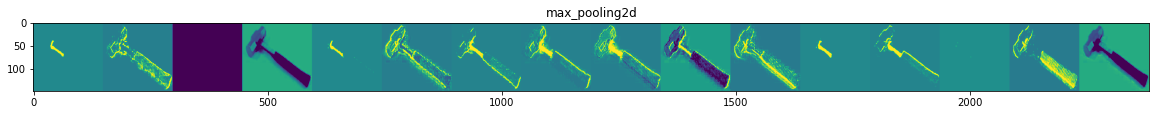

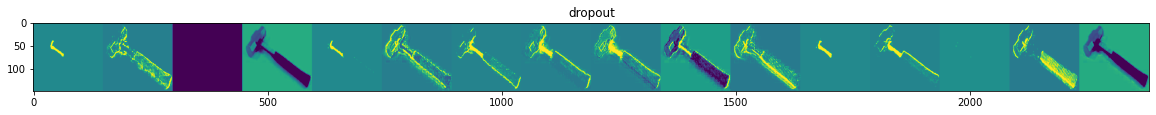

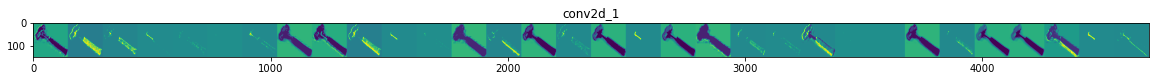

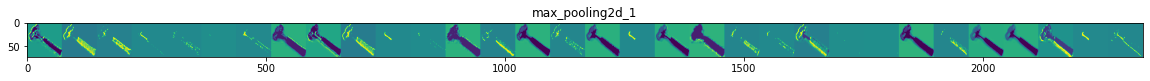

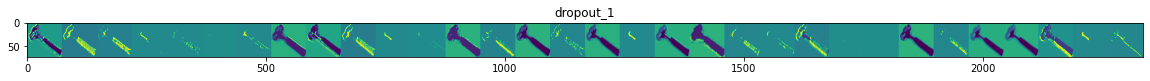

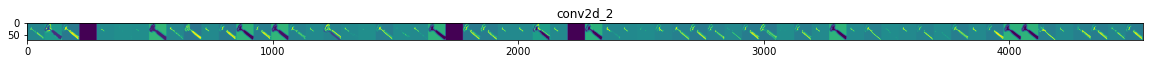

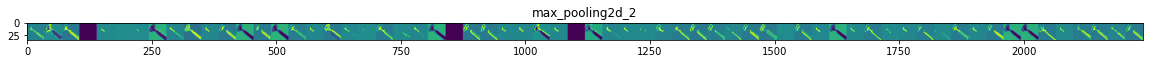

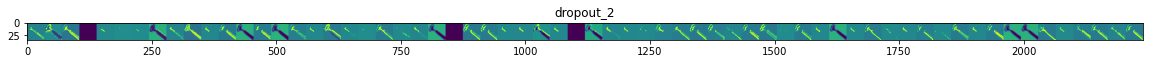

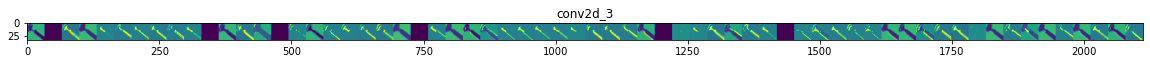

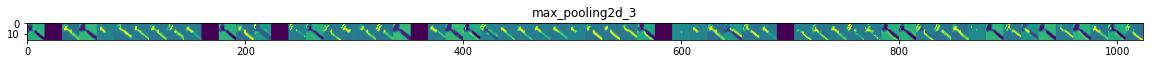

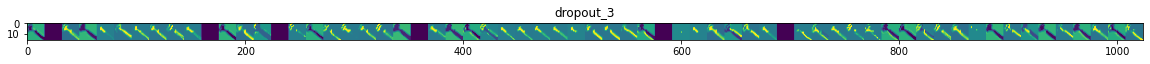

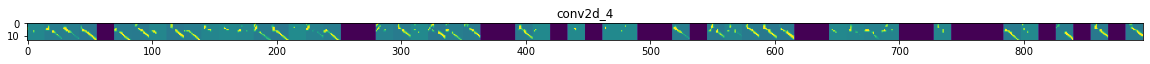

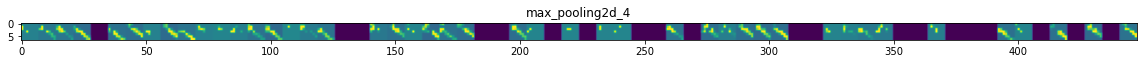

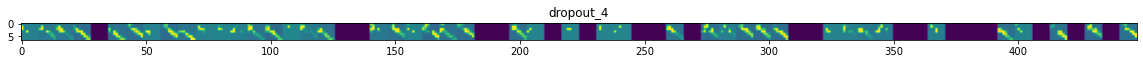

In [18]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
hammer_img_files = [os.path.join(train_hammer_dir, f) for f in train_hammer_names]
screw_img_files = [os.path.join(train_Screwdriver_dir, f) for f in train_screw_names]
img_path = random.choice(hammer_img_files + screw_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
    # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
      # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')